<a href="https://colab.research.google.com/github/vectice/vectice-examples/blob/master/MLflow/Diamonds_Price_Prediction/Diamonds_Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks you through the Vectice integration with MLflow

## Install Vectice, MLflow and GCS packages

In order to keep the Vectice library lite, we install just the primary dependencies and let the user install the the other dependencies when needed. Here, we install github because our notebook is on Github and we are going to need the github package to be able to point to the notebook from the Vectice UI. You have to add the other dependencies (gitlab, bitbucket) if you're going to use them (!pip install -q "vectice[github, gitlab, bitbucket]")

In [1]:
!pip3 install -q vectice[github]==2.2.3
!pip3 install -q fsspec
!pip3 install -q gcsfs
!pip3 install -q google-cloud-storage
!pip3 install -q mlflow

     |████████████████████████████████| 121 kB 5.1 MB/s 
     |████████████████████████████████| 291 kB 38.9 MB/s 
     |████████████████████████████████| 856 kB 61.8 MB/s 
     |████████████████████████████████| 136 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 7.4 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 49.8 MB/s 
     |████████████████████████████████| 144 kB 41.1 MB/s 
     |████████████████████████████████| 17.8 MB 370 kB/s 
     |████████████████████████████████| 146 kB 49.3 MB/s 
     |████████████████████████████████| 210 kB 52.6 MB/s 
     |████████████████████████████████| 181 kB 50.1 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 62 kB 781 kB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |█████████████████████

In [2]:
!pip3 show vectice

Name: vectice
Version: 2.2.3
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: requests, python-dotenv, urllib3
Required-by: 


The main entrypoint of the SDK is the high level API which provide several solutions to follow your runs.

* a procedural solution with 2 methods to call vectice.create_run() and vectice.save_after_run()

* a more powerful solution based on vectice.Vectice class that provides itself several possibilities:

* use an instance of vectice.Vectice object to create_run(), start_run() and end_run() (fluent API)

* You can also use the context manager syntax (python with keyword): In this case, the end of the run will be automatically managed.

In [1]:
import logging
from math import sqrt
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn import metrics

import mlflow
from vectice import Experiment, Vectice
from vectice.api.json.artifact_type import JobArtifactType
from vectice.api.json.artifact_version import VersionStrategy
from vectice.api.json.model import ModelType
from vectice.api.json.job import JobType
from vectice.api.json.run import RunStatus
from vectice.models.dataset_metadata import DatasetMetadata

### Data:
This classic dataset contains the prices and other attributes of almost 54,000 diamonds. There are 10 attributes included in the dataset including the target ie. price.

### Feature description:

price price in US dollars ($326--$18,823)This is the target column containing tags for the features. 

### The 4 Cs of Diamonds:-

- carat (0.2--5.01) The carat is the diamond’s physical weight measured in metric carats.  One carat equals 1/5 gram and is subdivided into 100 points. Carat weight is the most objective grade of the 4Cs. 

- cut (Fair, Good, Very Good, Premium, Ideal) In determining the quality of the cut, the diamond grader evaluates the cutter’s skill in the fashioning of the diamond. The more precise the diamond is cut, the more captivating the diamond is to the eye.  

- color, from J (worst) to D (best) The colour of gem-quality diamonds occurs in many hues. In the range from colourless to light yellow or light brown. Colourless diamonds are the rarest. Other natural colours (blue, red, pink for example) are known as "fancy,” and their colour grading is different than from white colorless diamonds.  

- clarity (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) Diamonds can have internal characteristics known as inclusions or external characteristics known as blemishes. Diamonds without inclusions or blemishes are rare; however, most characteristics can only be seen with magnification.  

### Goal: 

The goal is to predict the prices of diamonds using the features in the given dataset. Thus it's a regression problem, you'll perform a bit of data cleaning and create a multiple models that are fed into MLflow. The code used to achieve this is hiddin but you can view it. However, it'll be more fun to give it a good old college try as a team and resort to the hidden code if all else fails.

Here is a link to the Python SDK Documentation, it's not final nor complete so you might need to troubleshoot a bit. 
[Python SDK Documentation](https://doc.vectice.com/)

Upload the GCS JSON. This is then declared as an environmental as seen below.

```
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'test.json'
```

In [ ]:
# In Google Collab you can upload the json file that has your Google Cloud Service account details, with the following widget. This is used to access the data needed to perform the steps in the notenook.
from google.colab import files
uploaded = files.upload()

## Vectice Credentials 

To connect to the Vectice App through the SDK you'll need the Project Token, Vectice API Endpoint and the Vectice API Token. You'll find all of this in the Vectice App. The Workspace allows you to create the Vectice API Token, in Projects you'll be able to get the Project Token, as seen below. The Vectice API Endpoint is 'https://beta.vectice.com'. You're provided with the GCS Service Account JSON, this will allow you to connect to the GCS Bucket in the Vectice App and get the needed data for the example. 

## Credentials Setup:
##### The Vectice API Endpoint and Token are needed to connect to the Vectice UI. Furthermore, a Google Cloud Storage credential JSON is needed to connect to the Google Cloud Storage to retrieve and upload the datasets. A project token links the runs to the relevant project and it's needed to create runs.

In [2]:
# Vectice API Endpoint
os.environ['VECTICE_API_ENDPOINT'] ='https://app.vectice.com'
# The connection API token created in the Vectice Workspace 
os.environ['VECTICE_API_TOKEN'] = "Vectice API Token"
# The Google Cloud Storage Service Account 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "readerKey.json"

In [3]:
# Intialize the connection with Vectice App
# Tip - auto_code=True automatically captures the source code of your experiments run. Check Remote Repository validates if the file is in the repository. 
experiment = Experiment(job="Diamonds", workspace="Workspace Reference", project="Project Reference", auto_code=True, check_remote_repository=False)
# Mid level API with a wider variety of API functionality.
vectice = Vectice(workspace="Workspace Reference", project="Project Reference")

In [4]:
# Create a Dataset in the Vectice UI. Allows you to pass resources in Dataset Versions 
dataset = vectice.create_dataset(name="Diamonds Test 2", connection="new new")

In [5]:
# Creates metadata for the dataset being used. In order for this to work the correct 'GOOGLE_APPLICATION_CREDENTIALS' must be set.  
files_metadata = DatasetMetadata.create_gcs("gs://vectice-examples-samples/Diamonds/diamonds.csv")
# Create a dataset version as an input for the run. 
dataset_version = experiment.add_dataset_version(dataset=dataset.id, version_name="Original Version", metadata=files_metadata)
# # Start the run 
experiment.start()

Run(id=4416, job=Job(name=Diamonds, id=2001, description=None, type=JobType.OTHER), name=Run 2022-05-19T08:26:03.926078, system_name=None, start_date=2022-05-19 08:26:15.689426, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=1920, model=None, version_number=None, version_id=None, version_name=Original Version, version_strategy=None, description=None, )], outputs=[])

The resources parameter in ```experiment.add_dataset_version ``` allows you to track your resources in a dataset and it's subsequent versions. There is an version_strategy that extends this, it can automatically keep track of hash changes and capture those changes as new dataset versions. The Dataset must have a connection set in order for this to work. Whereas the metadata parameter requires credenitals in the notebook level.

```
resources=["gs://vectice-examples-samples/Diamonds/diamonds.csv"]
```



In [4]:
data = pd.read_csv(r"gs://vectice-examples-samples/Diamonds/diamonds.csv")
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
# This shows you the number of rows and columns
data.shape

(53940, 10)

In [6]:
# The details of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


### Data Cleaing 
In machine learning, if the data is irrelevant or error-prone then it leads to an incorrect model being built.

In [7]:
#Dropping dimentionless diamonds
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
# We dropped 20 dimensionless entries
data.shape

(53920, 10)

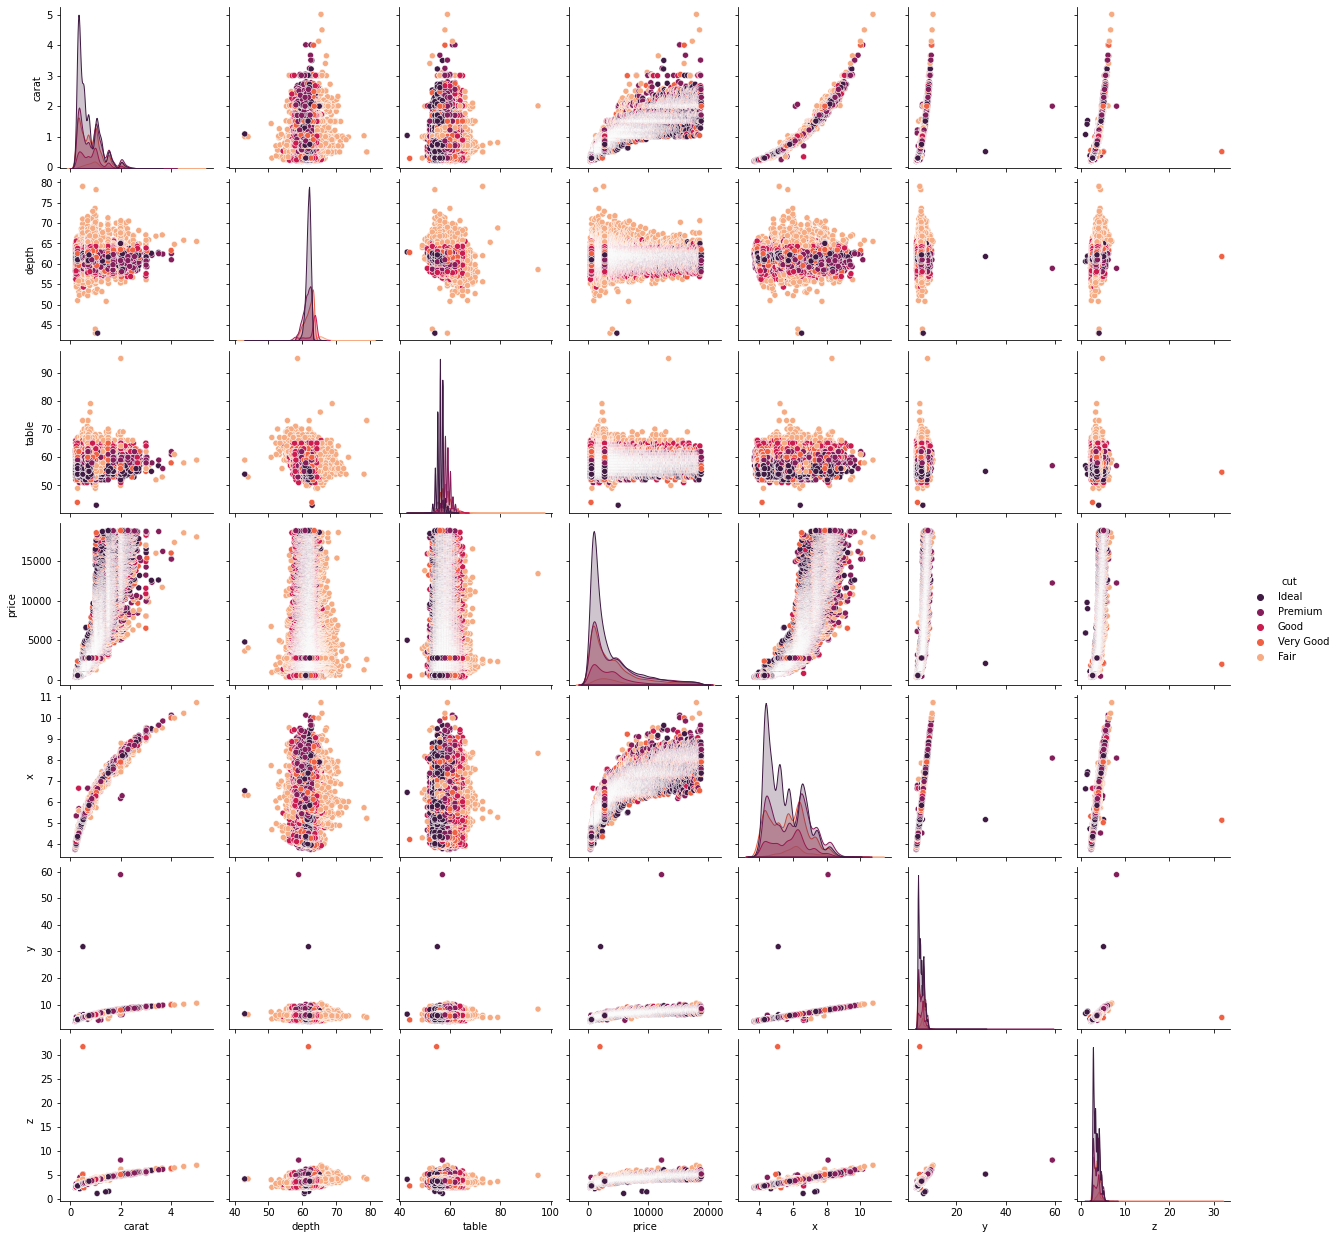

In [ ]:
sns.pairplot(data,hue= "cut", palette="rocket");

#### A few points to notice in these pair plots
##### There are some features with datapoints that are far from the rest of the dataset which will affect the outcome of our regression model.

* "y" and "z" have some dimensional outliers in our dataset that needs to be eliminated.
* The "depth" should be capped but we must examine the regression line to be sure.
* The "table" featured should be capped too.
* Let's have a look at regression plots to get a close look at the outliers.

In [ ]:
ax = sns.regplot(x="price", y="y", data=data, scatter_kws={'color': 'purple'}, line_kws={'color': 'orange'}).set(title="Regression Line on Price vs 'y'")

In [ ]:
ax = sns.regplot(x="price", y="z", data=data, scatter_kws={'color': 'purple'}, line_kws={'color': 'orange'}).set(title="Regression Line on Price vs 'z'")

In [ ]:
ax = sns.regplot(x="price", y="depth", data=data, scatter_kws={'color': 'purple'}, line_kws={'color': 'orange'}).set(title="Regression Line on Price vs 'depth'")

We can clearly spot outliers in these attributes. Next up, we will remove these data points.

In [ ]:
#Dropping the outliers. 
data = data[(data["depth"]<75)&(data["depth"]>45)]
data = data[(data["table"]<80)&(data["table"]>40)]
data = data[(data["x"]<30)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30)&(data["z"]>2)]
# We dropped 13 outliers
data.shape

Let us have another look at the pair plot of data.

In [ ]:
sns.pairplot(data, hue= "cut",palette="rocket");

That's a much cleaner dataset. Next, we will deal with the categorical variables.

In [8]:
# Get list of categorical variables
object_cols = [i for i in data.columns if data[i].dtype == 'object']
print(f"Categorical variables: {object_cols}")

Categorical variables: ['cut', 'color', 'clarity']


#### Why are Categorical Features important?
Machine learning models require all input and output variables to be numeric.

This means that if your data contains categorical data, you must encode it to numbers before you can fit and evaluate a model.

#### We have three categorical variables. Let us have a look at them with violin plots.
##### Violin plots are a method of plotting numeric data and can be considered a combination of the box plot with a kernel density plot. In the violin plot, we can find the same information as in the box plots:
* median (a white dot on the violin plot)
* interquartile range (the black bar in the center of violin)
* the lower/upper adjacent values (the black lines stretched from the bar) — defined as first quartile — 1.5 IQR and third quartile + 1.5 IQR respectively. These values can be used in a simple outlier detection technique (Tukey’s fences) — observations lying outside of these “fences” can be considered outliers.

![Image](https://miro.medium.com/max/520/1*TTMOaNG1o4PgQd-e8LurMg.png)

Probability Density Function:

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/525px-Boxplot_vs_PDF.svg.png)

In [ ]:
ax = sns.violinplot(x="cut", y="price", data=data).set(title="Violinplot for Cut vs Price")

In [ ]:
ax = sns.violinplot(x="color", y="price", data=data).set(title="Violinplot for Color vs Price")

In [ ]:
ax = sns.violinplot(x="clarity", y="price", data=data).set(title="Violinplot for Clarity vs Price")

#### Lable encoding the data to get rid of object dtype.
This approach is very simple and it involves converting each value in a column to a number. Consider a dataset of bridges having a column names bridge-types having below values. Though there will be many more columns in the dataset, to understand label-encoding, we will focus on one categorical column only.We choose to encode the text values by putting a running sequence for each text values like below:

![Markdown Logo is here.](https://miro.medium.com/max/289/1*VinegxkUYMzik9GpucWCFA.png)


In [9]:
# Make copy to avoid changing original data 
label_data = data.copy()

In [10]:
def encoder_labels(columns: list, dataframe: pd.DataFrame, encoder: LabelEncoder) -> pd.DataFrame:
    for col in columns:
        dataframe[col] = encoder.fit_transform(dataframe[col])
    return dataframe

In [11]:
encoder = LabelEncoder()
label_data = encoder_labels(object_cols, label_data, encoder)

In [13]:
label_data.head(5)

,0.00632 18.00 2.310 0 0.5380 6.5750 65.20 4.0900 1 296.0 15.30 396.90 4.98 24.00
0,23
1,22
2,32
3,110
4,27


In [ ]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


#### Correlation Matrix:
A correlation matrix is useful for showing the correlation coefficients (or degree of relationship) between variables. The correlation matrix is symmetric, as the correlation between a variable V1 and variable V2 is the same as the correlation between V2 and variable V1. Also, the values on the diagonal are always equal to one, because a variable is always perfectly correlated with itself.

In [ ]:
#correlation matrix
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,annot=True);

#### Points to notice:
* "x", "y" and "z" show a high correlation to the target column.
* "depth", "cut" and "table" show low correlation. We could consider dropping them but let's rather keep them.

In [14]:
files_metadata = DatasetMetadata.create_gcs("gs://vectice-examples-samples/Diamonds/diamonds_cleaned.csv")
# Create a new version of the orginal_cleaned dataset
# We already uploaded the cleaned data to GCS. You can create a dataset using this data
experiment.add_dataset_version(dataset="Diamonds Cleaned", version_name="Cleaned v1", metadata=files_metadata)
# End the run and save the new dataset version.
experiment.complete()

In [16]:
experiment = Experiment(job='Split Diamonds Data', workspace="Workspace Reference", project="Project Reference", job_type=JobType.PREPARATION)
# Create inputs 
experiment.add_dataset_version(dataset="Diamonds Cleaned", version_strategy=VersionStrategy.AUTOMATIC)
# Start a run to track this data train-test-split
# It will specify the dataset version we just created as the run's input.
experiment.start(auto_code=True, check_remote_repository=False)
# Start the run

Run(id=4417, job=Job(name=Split Diamonds Data, id=2021, description=None, type=JobType.PREPARATION), name=Run 2022-05-19T08:28:32.312571, system_name=None, start_date=2022-05-19 08:28:35.723460, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=Diamonds Cleaned, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, )], outputs=[])

In [17]:
train, test = train_test_split(label_data, test_size=0.2, random_state = 42)

In [18]:
# The key you were provided for this tutorial may not have write permissions to GCS.
# We already uploaded the data to GCS. You can create a dataset using this data and add it as the output of this run
experiment.add_dataset_version(dataset="Diamonds Train Test Split", version_strategy=VersionStrategy.AUTOMATIC)
# End the run
experiment.complete()

### Model Building
#### Steps involved in Model Building

* Setting up features and target
* Build a pipeline of standard scalar and model for five different regressors.
* Fit all the models on training data
* Get mean of cross-validation on the training set for all the models for negative root mean square error
* Pick the model with the best cross-validation score
* Fit the best model on the training set and predict on the test set

### Train-Test Split Evaluation 
The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

In [12]:
# Assigning the featurs as X and trarget as y
X = label_data.drop(["price"], axis =1)
y = label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

In [13]:
from mlflow.tracking import MlflowClient

# Initialise Experiment with MLflow 
experiment = Experiment(job="MLflow-Diamond-Models", workspace="Workspace Reference", project="Project Reference", lib=MlflowClient(tracking_uri="https://mlflow-beta.vectice.com"), job_type=JobType.TRAINING)

In [15]:
# Data preparation
def prepare_data():
    """Read and prepare data."""
    df = pd.read_csv(r"gs://vectice-examples-samples/Diamonds/diamonds_cleaned.csv")

    X = df.drop(["price"], axis =1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=42)

    return X_train, X_test, y_train, y_test

### Pipelines
In most machine learning projects the data that you have to work with is unlikely to be in the ideal format for producing the best performing model. There are quite often a number of transformational steps such as encoding categorical variables, feature scaling and normalisation that need to be performed. Scikit-learn has built in functions for most of these commonly used transformations in it’s preprocessing package.
However, in a typical machine learning workflow you will need to apply all these transformations at least twice. Once when training the model and again on any new data you want to predict on. Of course you could write a function to apply them and reuse that but you would still need to run this first and then call the model separately. Scikit-learn pipelines are a tool to simplify this process. They have several key benefits:
* They make your workflow much easier to read and understand.
* They enforce the implementation and order of steps in your project.
* These in turn make your work much more reproducible.

### StandardScaler Example:
A StandardScaler substarcts the mean and then divides by the standard deviation, this shifts the distribution to have a mean of 0 and a standard deviation of one.

In [ ]:
example = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
scaler = StandardScaler().fit(example)
X_scaled = scaler.transform(example)
print(f"Before: {example[0]} \nAfter: {X_scaled[0]}")

Before: [ 1. -1.  2.] 
After: [ 0.         -1.22474487  1.33630621]


### Cross Validation:

Cross validation follows the following logic. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using of the folds as training data;

- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

![Image](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

### Models:

1. LinearRegression <a href="https://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html" target="_blank">more info</a>.
2. DecisionTreeRegressor <a href="https://ml-cheatsheet.readthedocs.io/en/latest/classification_algos.html#decision-trees" target="_blank">more info</a>.
3. RandomForestRegressor <a href="https://www.geeksforgeeks.org/random-forest-regression-in-python/" target="_blank">more info</a>.
4. KNeighborsRegressor <a href="https://ml-cheatsheet.readthedocs.io/en/latest/classification_algos.html#k-nearest-neighbor" target="_blank">more info</a>.
5. XGBRegressor <a href="https://machinelearningmastery.com/xgboost-for-regression/" target="_blank">more info</a>.

In [16]:
import warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)
"""Vectice MLflow adapter fluent usage in Python ``with`` syntax."""
X_train, X_test, y_train, y_test = prepare_data()

mlflow.autolog(silent=True)

# Building pipelins of standard scaler and model for regressors.
pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                 ("Diamonds_Regressor",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                    ("Diamonds_Regressor",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                    ("Diamonds_Regressor",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                    ("Diamonds_Regressor",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                    ("Diamonds_Regressor",XGBRegressor())])

# Pipelines list to iterate over
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

for pipe in pipelines:
    # Expermient name for each pipeline 
    MLFLOW_EXPERIMENT_NAME = pipe.steps[1][0]
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    algorithm = pipe.steps[1][1]
    
    # Fit each model 
    pipe.fit(X_train, y_train)
    with experiment.start():
        # Add Dataset Version as an Input for each run.
        experiment.add_dataset_version(dataset="Diamonds Train Test Split", artifact_type=JobArtifactType.INPUT)
        cv_score = cross_val_score(pipe, X_train, y_train,scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
        mlflow.log_param('Algorithm', algorithm)
        mlflow.log_param('Scaler', 'StandardScaler')
        mlflow.log_metric("Cross Validation", float(cv_score.mean()))
        print(f"{MLFLOW_EXPERIMENT_NAME}: {cv_score.mean()}")

2022/05/19 08:34:06 INFO mlflow.tracking.fluent: Experiment with name 'MLflow-Diamond-Models' does not exist. Creating a new experiment.


Diamonds_Regressor: -1347.6929789207643
Diamonds_Regressor: -744.6904040610021
Diamonds_Regressor: -551.3193191841938
Diamonds_Regressor: -820.8029438231827
[08:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Diamonds_Regressor: -671.1095432970793


we can have the list of models in the project by using vectice.list_models()

In [17]:
experiment.list_models()

[Model(name=MLflow-Diamond-Models, id=998, description=None, type=ModelType.OTHER),
 Model(name=MLflow-Diamond release, id=997, description=None, type=ModelType.OTHER),
 Model(name=MLflow-Diamondzzzz, id=996, description=None, type=ModelType.OTHER),
 Model(name=MLflow-Diamonds, id=995, description=None, type=ModelType.OTHER),
 Model(name=MLflow Diamonds, id=986, description=None, type=ModelType.OTHER),
 Model(name=mlflow-job-multiple, id=994, description=None, type=ModelType.OTHER),
 Model(name=mlflow-job-10, id=993, description=None, type=ModelType.OTHER),
 Model(name=mlflow-job-5, id=991, description=None, type=ModelType.OTHER),
 Model(name=MLflow Diamonds 4, id=990, description=None, type=ModelType.OTHER),
 Model(name=MLflow Diamonds 3, id=989, description=None, type=ModelType.OTHER),
 Model(name=MLflow Diamonds 2, id=988, description=None, type=ModelType.OTHER),
 Model(name=A Model That Does Not Exist, id=987, description=None, type=ModelType.OTHER),
 Model(name=Does not exist, id=

We can update an existing model by using vectice.update_model()

In [20]:
experiment.update_model("MLflow-Diamond-Models", type=ModelType.REGRESSION)

Model(name=MLflow-Diamond-Models, id=998, description=None, type=ModelType.REGRESSION)

#### Testing the Model with the best score on the test set
In the above scores, Random Forest appears to be the model with the best scoring on negative root mean square error. Let's test this model on a test set and evaluate it with different parameters. But you might get different results.

In [ ]:
# If you have a mlflow run that is still running and you need to end it, then run this cell.
mlflow.end_run()

In [21]:
# Model prediction on test data
pred = pipeline_rf.predict(X_test)

In [22]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9801545400964425
Adjusted R^2: 0.9801412773698418
MAE: 264.81263809241136
MSE: 301048.2996842575
RMSE: 548.6786852833427


#### End

Congratulations and as Jake Peralta would say:

![Image](https://i.imgur.com/I1wR7mE.gif?noredirect)